# Fine tuning of AdaBoost Classifier model

## for binary classification

In [2]:
from pathlib import Path
# import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import (
    make_scorer, f1_score, classification_report,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)

# models
from sklearn.ensemble import GradientBoostingClassifier

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/multiclass'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 24)
(2026, 24)
(8103,)
(2026,)


In [6]:
# numeric features that need transformation
real_features = [
    'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp',
    'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
    'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
    'S5_CO2', 'S5_CO2_Slope',
    'mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound'
]

# scorer: F1 score
scorer = make_scorer(score_func=f1_score, average='micro')

# 10x Repeated 5-fold cross-validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

### Tuning without PCA

In [8]:
def get_search_results(X_train, y_train, param_grid: dict) -> dict:
    
    model = GradientBoostingClassifier(
        n_iter_no_change=10,
        validation_fraction=0.2,
        random_state=42,
    )

    numTransformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numTransformer, real_features),
        ]
    )

    estimator = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    search = HalvingGridSearchCV(
        estimator, param_grid, 
        factor=2, 
        cv=kf, 
        scoring=scorer, 
        refit=True, 
        verbose=1, 
        resource='model__n_estimators',
        max_resources=500
    )
    search.fit(X_train, y_train)
        
    return search

In [18]:
def report_results(results: dict) -> None:
    
    # print best parameter combination
    print(f'Best parameters:\n{results.best_params_}\n')
    # print best score
    print(f'Best score:\n{results.best_score_}\n')
    
    # plot heatmap
    df = pd.DataFrame(results.cv_results_)
    df = df.drop_duplicates(
        subset=[
            'param_model__subsample',
            'param_model__max_depth',
            'param_model__max_features',
            'param_model__learning_rate',
            'param_model__n_estimators', 
        ], 
        keep='last'
    )
    df['rank'] = df['mean_test_score'].rank(method='min', ascending=False).astype(int)

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    for md in df['param_model__max_depth'].unique():
        for subs in df['param_model__subsample'].unique():        
            for mf in df['param_model__max_features'].unique():
                print(f'max_depth = {md}  subsample = {subs}  max_features = {mf}')
                
                df_p = df[(df['param_model__max_depth'] == md) & (df['param_model__subsample'] == subs) & (df['param_model__max_features'] == mf)]
                data = df_p.pivot_table(index='param_model__learning_rate', columns='param_model__n_estimators', values='mean_test_score', aggfunc=np.max, fill_value=0)
                annot = df_p.pivot_table(index='param_model__learning_rate', columns='param_model__n_estimators', values='rank', aggfunc=np.min, fill_value=0)    

                sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt='d')
                plt.show()

In [10]:
np.logspace(-3, 3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [11]:
param_grid = {
    'model__learning_rate': np.logspace(-3, 2, 6),
    'model__subsample': [0.5, 0.75, 1],
    'model__max_depth': [2, 3, 5],
    'model__max_features': ['sqrt', 'log2', 1.0]
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 3
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 162
n_resources: 3
Fitting 50 folds for each of 162 candidates, totalling 8100 fits
----------
iter: 1
n_candidates: 81
n_resources: 6
Fitting 50 folds for each of 81 candidates, totalling 4050 fits
----------
iter: 2
n_candidates: 41
n_resources: 12
Fitting 50 folds for each of 41 candidates, totalling 2050 fits
----------
iter: 3
n_candidates: 21
n_resources: 24
Fitting 50 folds for each of 21 candidates, totalling 1050 fits
----------
iter: 4
n_candidates: 11
n_resources: 48
Fitting 50 folds for each of 11 candidates, totalling 550 fits
----------
iter: 5
n_candidates: 6
n_resources: 96
Fitting 50 folds for each of 6 candidates, totalling 300 fits
----------
iter: 6
n_candidates: 3
n_resources: 192
Fitting 50 folds for each of 3 candidates, totalling 150 fits
----------
iter: 7
n_candidates: 2
n_resources: 38

Best parameters:
{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__subsample': 0.75, 'model__n_estimators': 384}

Best score:
0.9967418374574453

max_depth = 2  subsample = 0.5  max_features = sqrt


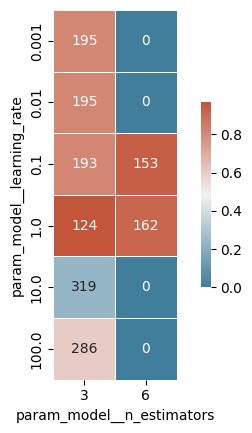

max_depth = 2  subsample = 0.5  max_features = log2


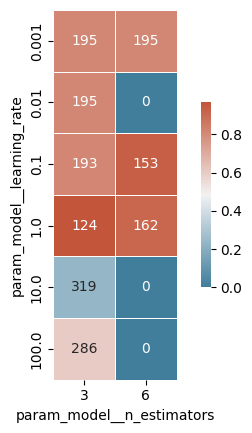

max_depth = 2  subsample = 0.5  max_features = 1.0


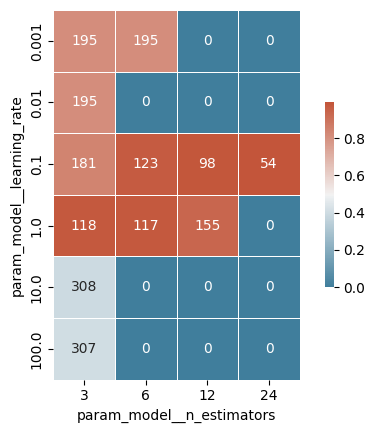

max_depth = 2  subsample = 0.75  max_features = sqrt


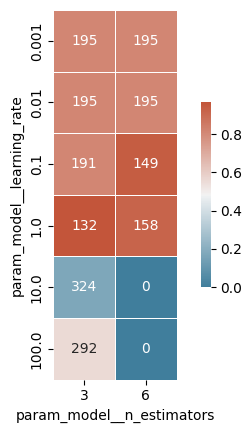

max_depth = 2  subsample = 0.75  max_features = log2


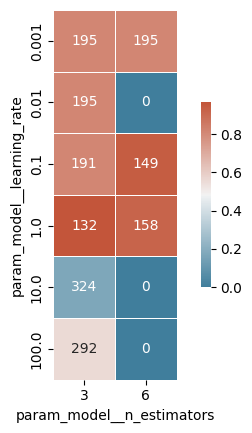

max_depth = 2  subsample = 0.75  max_features = 1.0


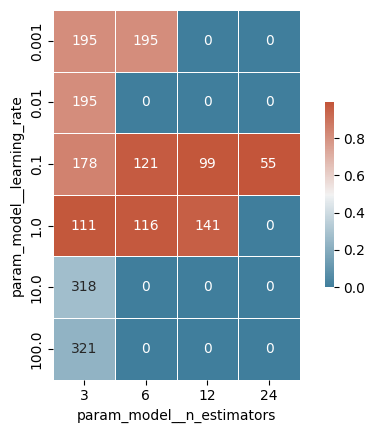

max_depth = 2  subsample = 1  max_features = sqrt


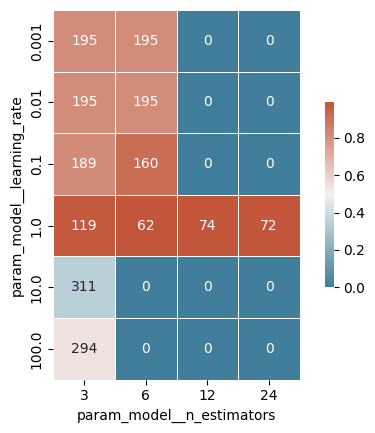

max_depth = 2  subsample = 1  max_features = log2


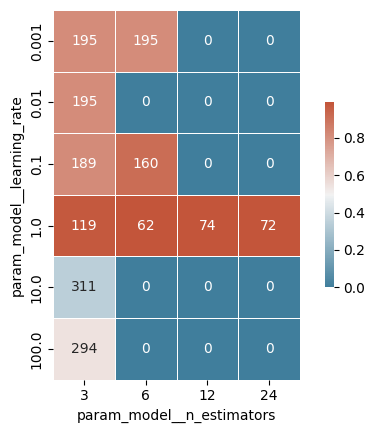

max_depth = 2  subsample = 1  max_features = 1.0


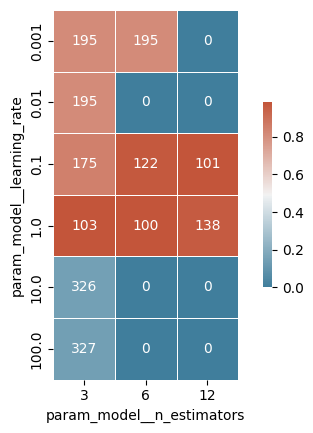

max_depth = 3  subsample = 0.5  max_features = sqrt


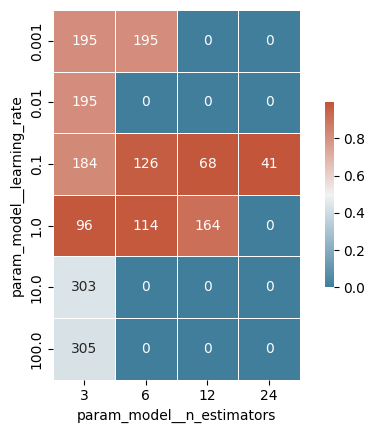

max_depth = 3  subsample = 0.5  max_features = log2


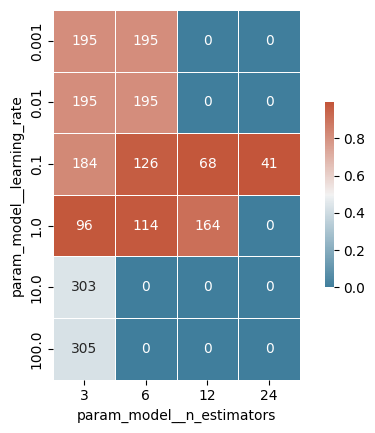

max_depth = 3  subsample = 0.5  max_features = 1.0


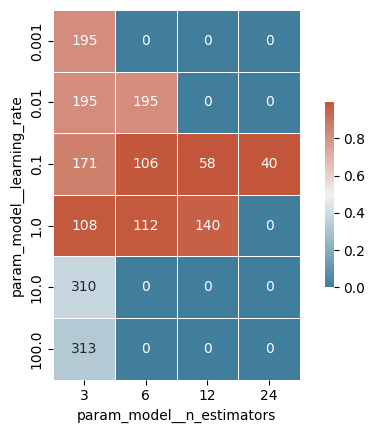

max_depth = 3  subsample = 0.75  max_features = sqrt


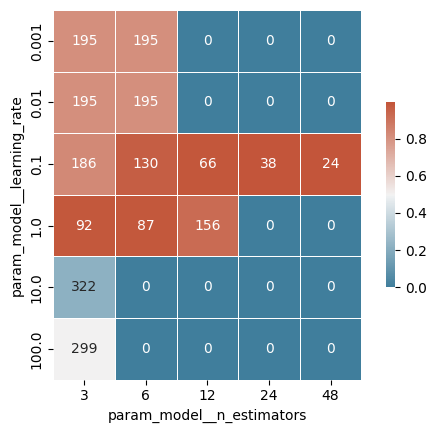

max_depth = 3  subsample = 0.75  max_features = log2


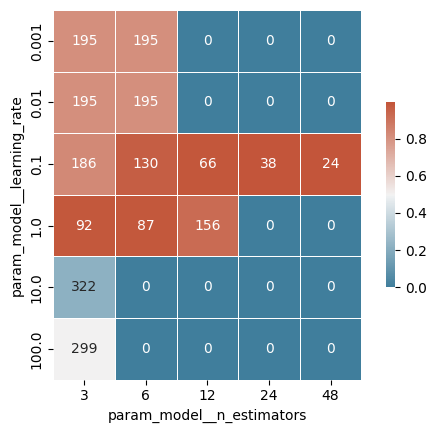

max_depth = 3  subsample = 0.75  max_features = 1.0


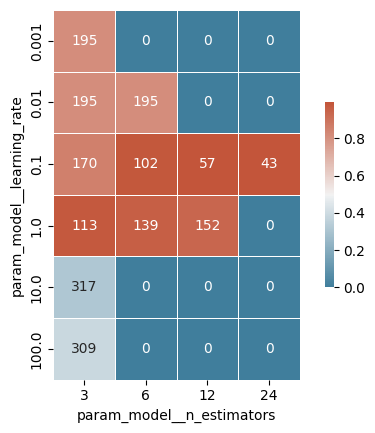

max_depth = 3  subsample = 1  max_features = sqrt


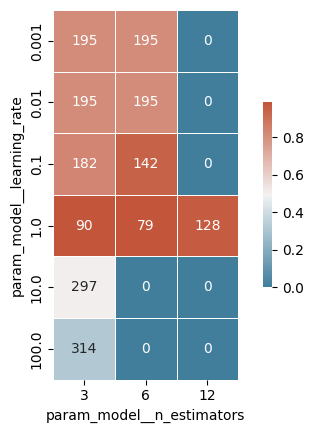

max_depth = 3  subsample = 1  max_features = log2


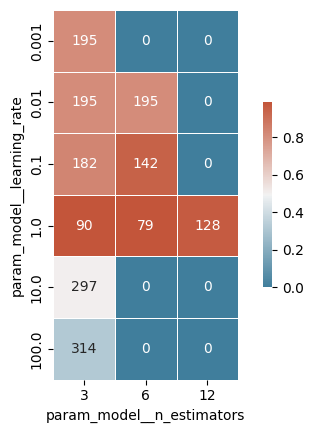

max_depth = 3  subsample = 1  max_features = 1.0


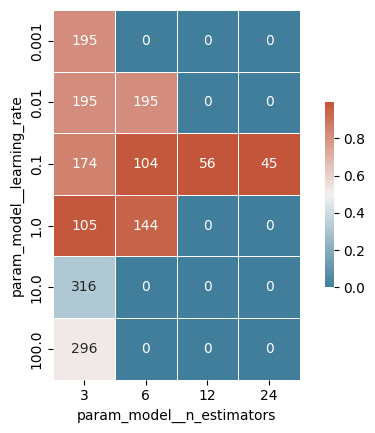

max_depth = 5  subsample = 0.5  max_features = sqrt


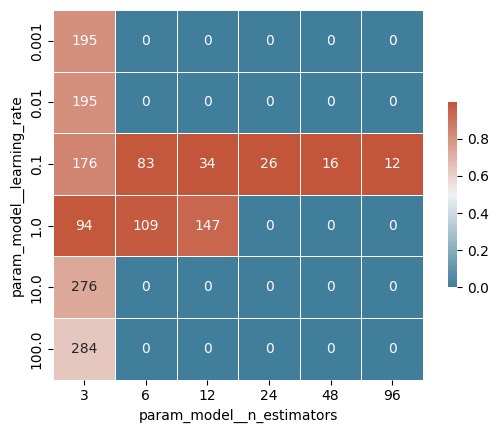

max_depth = 5  subsample = 0.5  max_features = log2


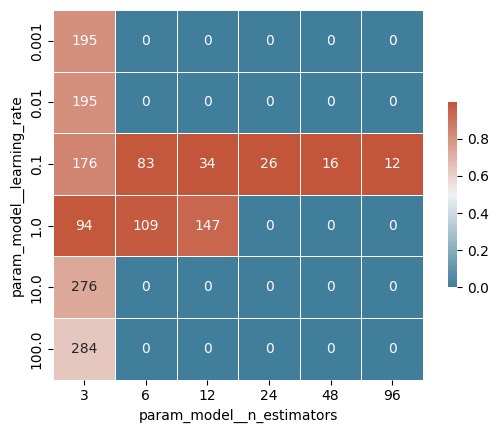

max_depth = 5  subsample = 0.5  max_features = 1.0


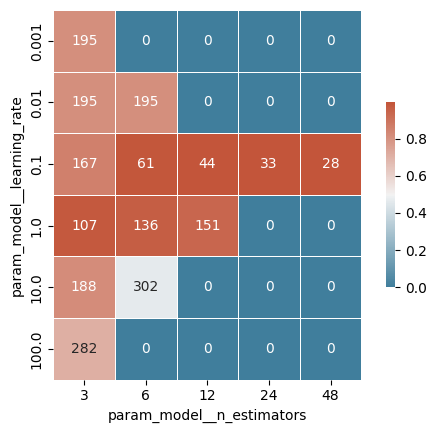

max_depth = 5  subsample = 0.75  max_features = sqrt


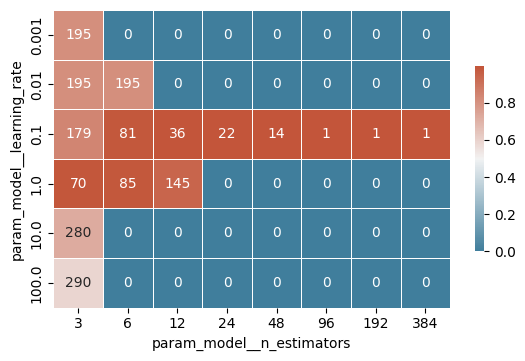

max_depth = 5  subsample = 0.75  max_features = log2


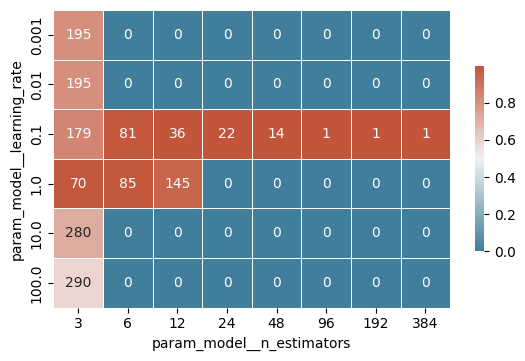

max_depth = 5  subsample = 0.75  max_features = 1.0


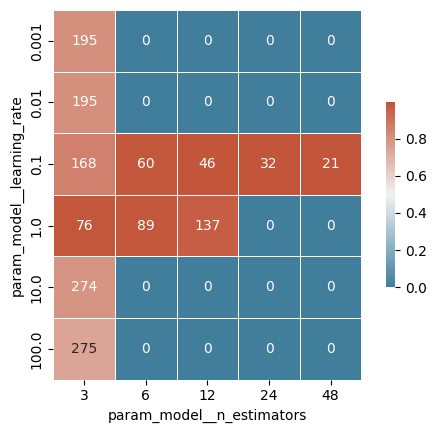

max_depth = 5  subsample = 1  max_features = sqrt


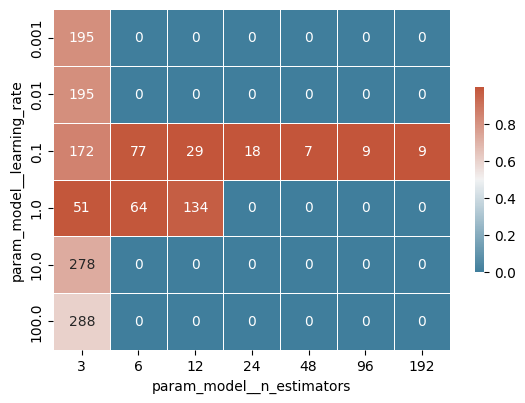

max_depth = 5  subsample = 1  max_features = log2


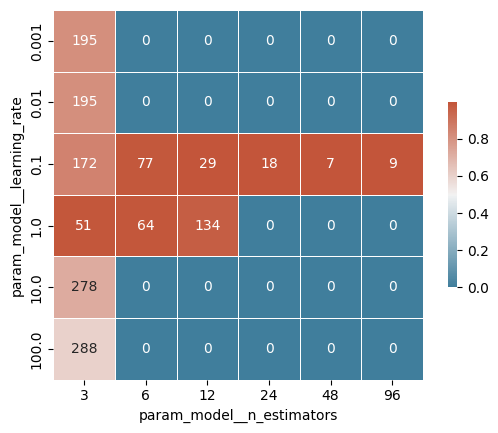

max_depth = 5  subsample = 1  max_features = 1.0


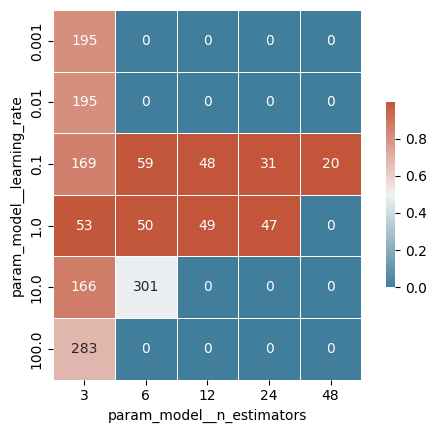

In [19]:
report_results(results)

### Fine-tuning for the most promising region

In [20]:
param_grid = {
    'model__learning_rate': [0.1],
    'model__subsample': [0.75, 0.87, 1],
    'model__max_depth': [5, 8, 11],
    'model__max_features': ['sqrt', 'log2']
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 31
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 31
Fitting 50 folds for each of 18 candidates, totalling 900 fits
----------
iter: 1
n_candidates: 9
n_resources: 62
Fitting 50 folds for each of 9 candidates, totalling 450 fits
----------
iter: 2
n_candidates: 5
n_resources: 124
Fitting 50 folds for each of 5 candidates, totalling 250 fits
----------
iter: 3
n_candidates: 3
n_resources: 248
Fitting 50 folds for each of 3 candidates, totalling 150 fits
----------
iter: 4
n_candidates: 2
n_resources: 496
Fitting 50 folds for each of 2 candidates, totalling 100 fits


Best parameters:
{'model__learning_rate': 0.1, 'model__max_depth': 11, 'model__max_features': 'sqrt', 'model__subsample': 1, 'model__n_estimators': 496}

Best score:
0.9969145931866475

max_depth = 5  subsample = 0.75  max_features = sqrt


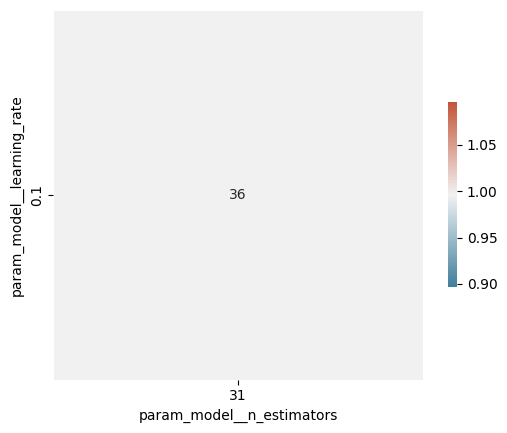

max_depth = 5  subsample = 0.75  max_features = log2


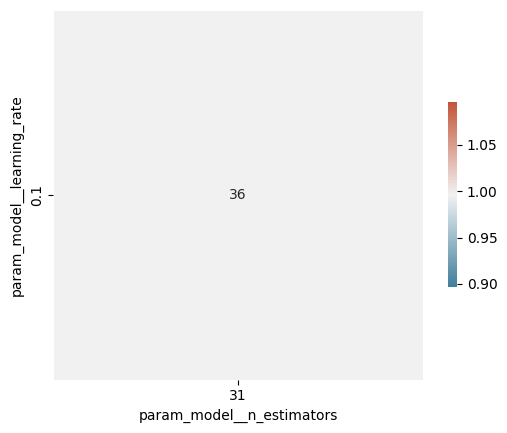

max_depth = 5  subsample = 0.87  max_features = sqrt


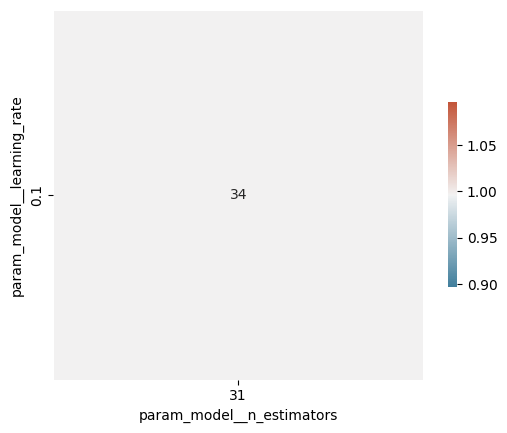

max_depth = 5  subsample = 0.87  max_features = log2


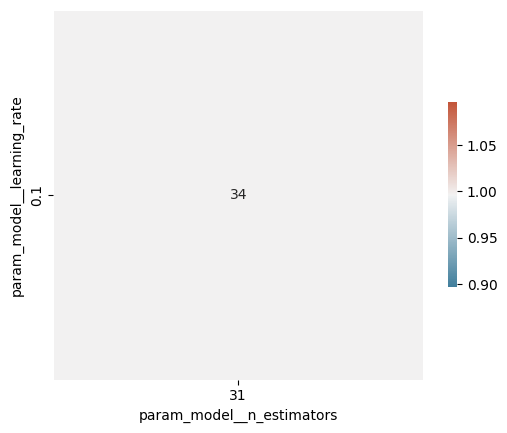

max_depth = 5  subsample = 1  max_features = sqrt


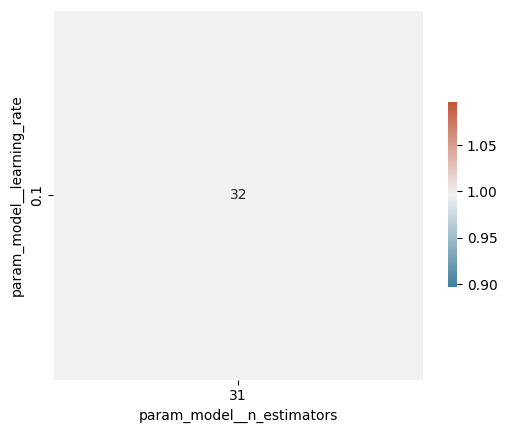

max_depth = 5  subsample = 1  max_features = log2


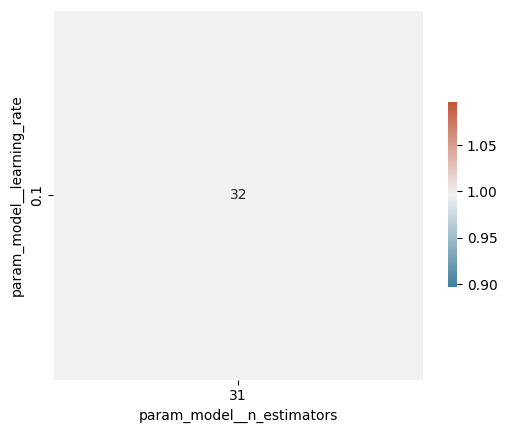

max_depth = 8  subsample = 0.75  max_features = sqrt


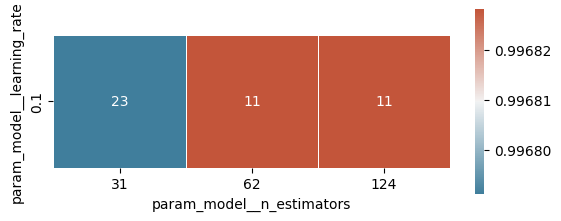

max_depth = 8  subsample = 0.75  max_features = log2


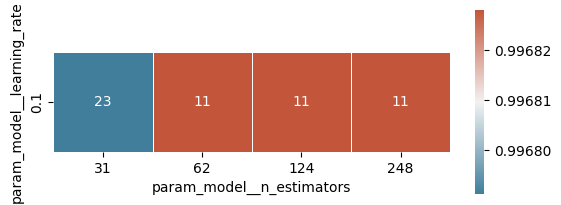

max_depth = 8  subsample = 0.87  max_features = sqrt


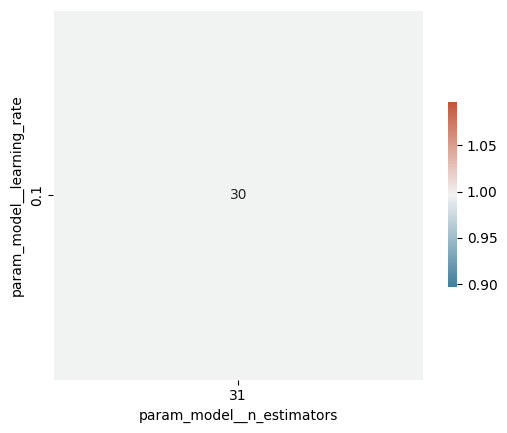

max_depth = 8  subsample = 0.87  max_features = log2


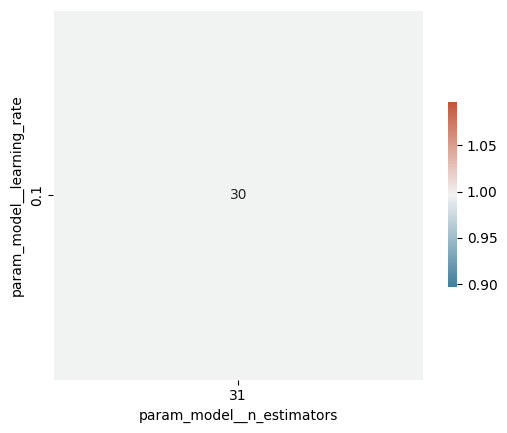

max_depth = 8  subsample = 1  max_features = sqrt


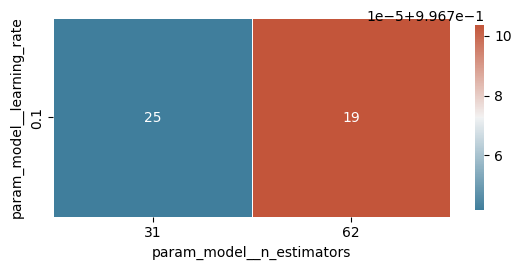

max_depth = 8  subsample = 1  max_features = log2


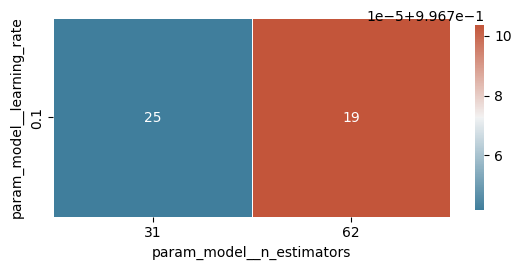

max_depth = 11  subsample = 0.75  max_features = sqrt


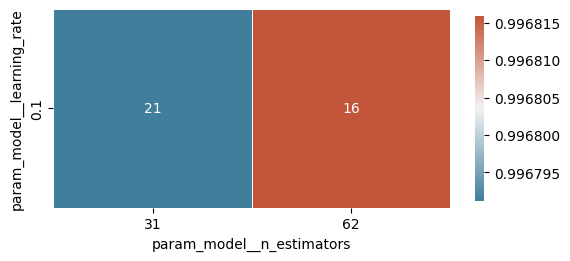

max_depth = 11  subsample = 0.75  max_features = log2


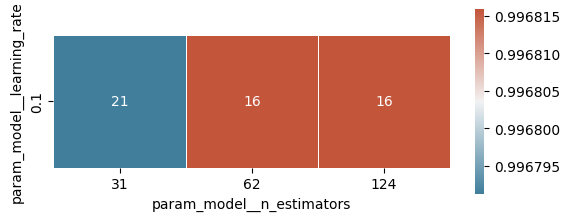

max_depth = 11  subsample = 0.87  max_features = sqrt


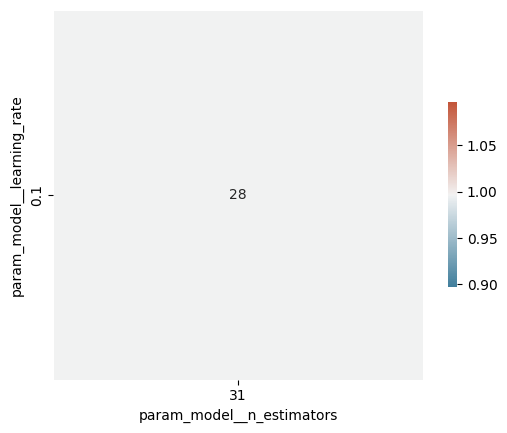

max_depth = 11  subsample = 0.87  max_features = log2


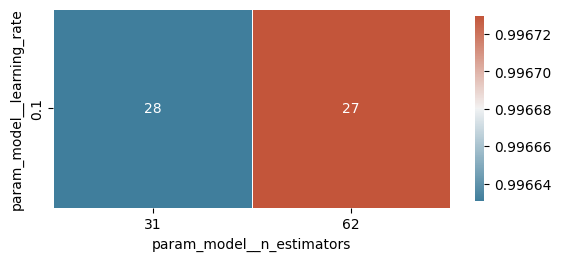

max_depth = 11  subsample = 1  max_features = sqrt


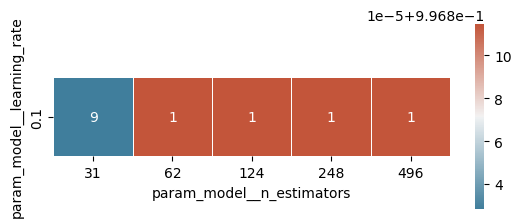

max_depth = 11  subsample = 1  max_features = log2


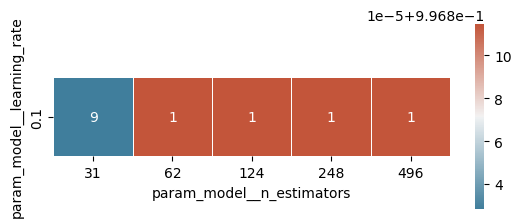

In [21]:
report_results(results)

## Best model cross-validation performance

In [22]:
scores = pd.DataFrame(results.cv_results_).filter(regex='split\d{1,2}_test', axis=1).iloc[results.best_index_, :].to_list()
mean = np.mean(scores)
median = np.median(scores)
lower = max(0.0, np.percentile(scores, 2.5))
upper = min(1.0, np.percentile(scores, 97.5))
print(f"Mean: {mean:.4f}")
print(f"Median: {median:.4f}")
print(f"95% confidence interval: ({lower:.4f} - {upper:.4f})")

Mean: 0.9969
Median: 0.9972
95% confidence interval: (0.9938 - 0.9999)


## Evaluate best model on hold-out test dataset

In [23]:
y_pred = results.best_estimator_.predict(X_test)

In [24]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997      1646
           1     0.9892    1.0000    0.9946        92
           2     0.9671    0.9866    0.9767       149
           3     0.9925    0.9568    0.9744       139

    accuracy                         0.9961      2026
   macro avg     0.9871    0.9859    0.9863      2026
weighted avg     0.9961    0.9961    0.9960      2026



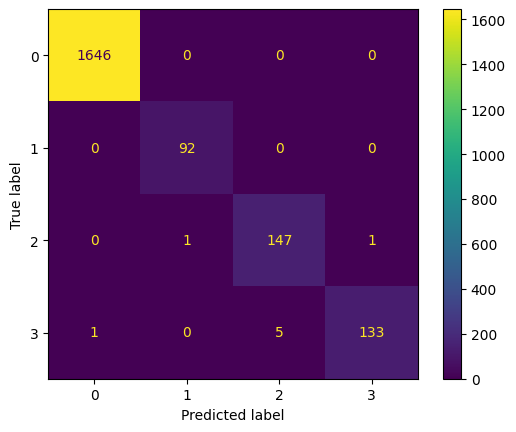

In [25]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()